First, import some useful packages and set everything up (e.g., inline plotting)

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from math import *

Let's start with defining the solution for least squares regression in closed form

In [2]:
# compute parameters of the linear regression of phi(x)->y
# Inputs:
#   x, y: the training data and labels, respectively
#   transform: function mapping x to features phi(x)
# Output:
# w : parameters of the trained model
def lr_closed_form(x,y,transform):
    return np.dot(np.linalg.pinv(transform(x)),y)        

The function below (that perhaps could be simplified) defines a generalized polynomial feature expansion, specified as a list of degrees.

In [3]:
def polyFv(x,degs,mu=None,sigma=None):
    # Map m-dim input vector x to [x_1^d_1, x_2^d_1,...,x_m^d_1,x_1^d_2,...,x_m^d_k]
    # where degs is the list (d_1,...,d_k)
    # if d_j=0, only include a single copy of 1 (and not m copies)
    #
    # If mu and sigma are passed, this function will normalize each feature j, subtracting mu[j] and dividing by sigma[j].
    # If mu and sigma are not passed: they will be calculated, and returned as additional outputs, so the function will
    #   return a tuple (X,mu,sigma); if you want to just compute the feature map, but do not pass mu/sigma, then use
    #   polyFv(x)[0]
    
    nd=len(degs)
    
    if len(x.shape)==1:
        x=x[:,np.newaxis] # force a "data matrix" form, even if there's only a single feature
    N,m=x.shape
    
    # calculate the dimension of the transformed feature vector phi(x)
    if 0 in degs:
        M=(len(degs)-1)*m+1
    else:
        M=len(degs)*m
        
    X=np.empty([N,M])
    if 0 in degs:
        X[:,0]=1
        j=1
    else:
        j=0 # index to keep track of where to write the next chunk of features
        
    for d in range(len(degs)):
        if degs[d] != 0:
            X[:,j:j+m]=x**degs[d]
            j=j+m
            
    # normalize
    if mu is None:
        mu = X.mean(0)
        sigma = X.std(0)
        sigma[0]=1
        sigma[sigma<0.0001]=1 # to avoid division by zero
        return_normalizer = True
    else:
        return_normalizer = False
        
    X=(X-mu)/sigma
    
    if 0 in degs:
        X[:,0]=1

    if return_normalizer:
        return X, mu, sigma
    else:
        return X

# Toy experiment with 1D regression

Before we work on a real dataset with a multi-dimensional input space, let's explore regression in 1D inputs, which is easy to visualize. We will do this with a <i>synthetic</i> data domain, where we simply generate the data from a noisy model.
Note that in this case, contrary to the real world scenario, we can ask how well the regression method recovers the true model; in the real world case this is of course not a meaningful question because we will never know the true model.

In [4]:
# generate range of 1d xs, from -2 to 2, with a given step
def genXrange(step):
    xt=np.arange(-2,2,step)
    xtick=np.empty([xt.shape[0],1])
    xtick[:,0]=xt
    return xtick

In [5]:
# generate a dataset {(x,y)} where y = f(x) + noise
# n: # of examples
# sigma: std. deviation of the noise in y
# f: the function accounting for the deterministic component in y
def genD(n,sigma,f):
    
    # first get xs -- jitter them around a bit with uniform noise
    xraw=np.linspace(-2,2,n)
    xnoise=np.random.uniform(-.1,.1,xraw.shape)
    x=np.empty([xraw.shape[0],1])
    x[:,0]=xraw+xnoise
    
    # now generate ys
    y=f(x)
    ynoise=np.random.normal(0,sigma,y.shape)
    y=np.squeeze(y+ynoise)
    
    return x,y

In [6]:
# the function we will be using as the source of our x->y data. You can see how modifying f,
# for example making it more or less smooth, affects the experiments below.
def f(x):
    return np.sin(x*1.7)+.1*x**2+3

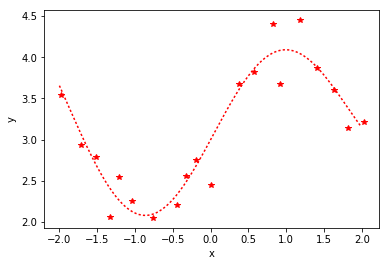

In [7]:
# let's test it out: generate a dataset and plot it
x, y = genD(20,.3,f)

plt.plot(x,y,'r*')
plt.xlabel('x')
plt.ylabel('y');

# and also plot the function over a dense 1D "grid" of x values
xtick=genXrange(.01)
plt.plot(xtick,f(xtick),'r:')

Now we are going to build a simple toolkit for 1D regression. It will be limited to solving least squares in closed form, but powerful enough to allow non-linear features.

In [8]:
# define some feature maps
# we could define a separate function for each set of features, but using lambda expressions
# seems more convenient

# the code below is a correction:
# (Thanks to Takahiro Maeda and Takeru Oba for pointing this out. --KG 10/16/2019)
_, muL, sigmaL = polyFv(x,(0,1))
_, muQ, sigmaQ = polyFv(x,(0,1,2))
_, mu3, sigma3 = polyFv(x,range(0,4))
_, mu7, sigma7 = polyFv(x,range(0,8))
_, mu15, sigma15 = polyFv(x,range(0,21))

mapLinear = lambda x: polyFv(x,(0,1),muL,sigmaL)
map2 = lambda x: polyFv(x,(0,1,2),muQ,sigmaQ)
map3 = lambda x: polyFv(x,range(0,4),mu3,sigma3)
map7 = lambda x: polyFv(x,range(0,8),mu7,sigma7)
map15 = lambda x: polyFv(x,range(0,21),mu15,sigma15)

# original code follows:
#mapLinear = lambda x: polyFv(x,(0,1))[0]
#map2 = lambda x: polyFv(x,(0,1,2))[0]
#map3 = lambda x: polyFv(x,range(0,4))[0]
#map7 = lambda x: polyFv(x,range(0,8))[0]
#map15 = lambda x: polyFv(x,range(0,16))[0]

In [9]:
# a function to conveniently visualize the regression model, plotting it over a dense grid of inputs
# Input:
#   w : the regression model (parameter vector)
#   transform: the feature transform mapping x to phi(x)
#   style: line style
#   step: density of the grid on which the model is visualized
def plotLR(w,transform,style='k-',step=0.01):
    # sample inputs (xs) on a dense grid with given step
    xtick=genXrange(step)
    # predict y for each x using the model
    yhat=np.dot(transform(xtick),w)
    # draw the line (note: plot will interpolate the predictions, making it appear as a continuous line)
    plt.plot(xtick,yhat,style)

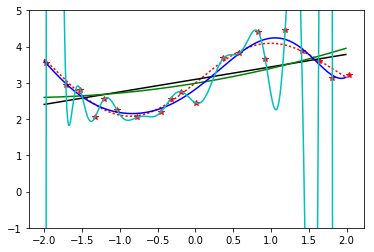

In [10]:
w1=lr_closed_form(x,y,mapLinear)
w2=lr_closed_form(x,y,map2)
w7=lr_closed_form(x,y,map7)
w15=lr_closed_form(x,y,map15)

plt.plot(x,y,'r*')
xtick=genXrange(.01)
plt.plot(xtick,f(xtick),'r:')

plotLR(w1,mapLinear,'k-')
plotLR(w2,map2,'g-')
plotLR(w7,map7,'b-')

plotLR(w15,map15,'c')
plt.ylim(-1,5);

Just as in the examples we saw in class, this shows that more complex models can fit the <i>training</i> data better. 
We can evaluate these models numerically, by computing training loss (avg. squared error) as well as the test loss (on the test set we will shortly generate). We will define an actual Python function that implements our (mathematical) loss function. 

Ignore the gradient related bits for now; we will need them later.

In [11]:
def lossSquared(X,y,w,getGrad=False):
    yhat = np.dot(X,w)
    err = np.squeeze(yhat)-y # prediction error values, for all the points in x
    loss = np.mean(err**2)
    if getGrad:
        grad = 2*np.mean(X*err.reshape(err.shape[0],1),axis=0)
        return loss, grad.reshape(w.shape)
    else:
        return loss

In [12]:
# make sure to use the same noise parameters and f as in generating the training set!
xTest, yTest = genD(100,.3,f)

In [13]:
Ms = (0,1,2,3,5,7,15,25)
polyModels = {}
errTrain = np.zeros((len(Ms)))

errTest = np.zeros((len(Ms)))

for m in range(len(Ms)):
    _,mu,sigma=polyFv(x,range(0,Ms[m]+1))
    transform = lambda x: polyFv(x,range(0,Ms[m]+1),mu,sigma)
    polyModels[m] = lr_closed_form(x,y,transform)
    errTrain[m] = lossSquared(transform(x),y,polyModels[m])
    errTest[m] = lossSquared(transform(xTest),yTest,polyModels[m])

In [14]:
print('\t\tTrain err\tTest err\n')
for m in range(len(Ms)):
    print('model %03d:\t%.04f\t\t%.04f'%(Ms[m],errTrain[m],errTest[m]))

		Train err	Test err

model 000:	0.5362		0.5979
model 001:	0.3583		0.3789
model 002:	0.3494		0.3613
model 003:	0.0698		0.0979
model 005:	0.0534		0.0873
model 007:	0.0463		0.0987
model 015:	0.0259		1.0829
model 025:	0.0000		162323.1969


So, as expected, more complex models reduce training RMSE, but at some point along the complexity axis, the test RMSE starts increasing, due to overfitting (this is also graphically evident in the plot, of course).

It would be interesting to see how this table would change if we had more training data than 20 points...

# Real Dataset: Boston Housing

We are now ready for some more realistic experiments. Let's consider the Boston Housing data set, originally from the UCI data repository. It's packaged with the scikit-learn distribution available with Anaconda, so it's easy to load it. It's in a rather fancy format, containing in addition to the raw data a description explaining what the features are.

The task here is to predict median house prices (in circa 1980 dollars, so don't be shocked! :-) based on various measurements of the neighborhoods in Boston.

In [15]:
import sklearn
from sklearn.datasets import load_boston
boston=load_boston()
print(boston.DESCR)

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

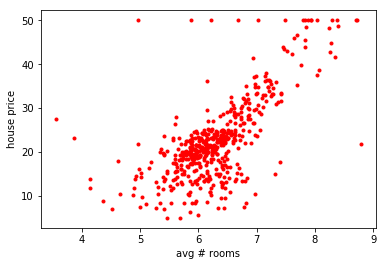

In [16]:
xhouse=boston.data
yhouse=boston.target
# visualize house price as a function of, say, "avg. number of rooms in a dwelling"
plt.plot(xhouse[:,5],yhouse,'r.')
plt.xlabel('avg # rooms')
plt.ylabel('house price');

We will first shuffle the data; to make sure everyone is working with the same partitions, we will fix the seed of the pseudorandom number generator.

In [17]:
np.random.seed(54321)
p = np.random.permutation(xhouse.shape[0])
xhouse=xhouse[p,:]
yhouse=yhouse[p]

We need to partition the data into train, val, and test. Let's put approximately 70% in train, 15% in val, and 15% in test. 

In [18]:

Ntrain=350
Nval=75
Ntest=xhouse.shape[0]-Ntrain-Nval

xtrain = xhouse[0:Ntrain,:]
ytrain = yhouse[0:Ntrain]
xval = xhouse[Ntrain:Ntrain+Nval,:]
yval = yhouse[Ntrain:Ntrain+Nval]
xtest = xhouse[Ntrain+Nval:,:]
ytest = yhouse[Ntrain+Nval:]

Instead of using the closed form solution, we will now try to learn the model using gradient descent.

Let's define a general-ish gradient descent routine. It will take as input the data (x,y), and the specifications of how to map the x to the feature space; how to run optimization; and how to evaluate loss (and its gradient).

In [19]:
def GD(x,y,transform,optim,lfunc):
    X = transform(x)
    w = np.zeros((X.shape[1]))
    converged = False
    
    lr=optim['lr']
    
    loss=np.empty([optim['maxiter']]) # will keep track of training loss
    
    t = 0 # iteration count
    while not converged:
        loss[t],lgrad = lfunc(X,y,w,getGrad=True)
        
        # 1) compute gradient-based update:
        w = w - optim['lr']*lgrad
        
        # 2) check for convergence:
        if t == optim['maxiter']-1: # exhausted iteration budget
            converged = True
        elif t >= optim['miniter'] and loss[t-optim['miniter']]/loss[t] < optim['mindelta']:
            # insufficient improvement compared to miniter iterations ago
            converged = True
        
        # 3) update learning rate and anything else you want to do as part of the optimization routine
        if t > 0 and t % optim['dropfreq']==0:
            lr=lr*optim['lrdrop']
        t=t+1
    
    loss=loss[:t]
    return w,loss

We will fill in some reasonable values for a few optimization-related parameters that you may want to use.

In [20]:
optim={}
optim['maxiter']=10000    # stop after at most this many iterations
optim['lr']=.01           # (initial) learning rate
optim['miniter']=50       # minimal number of iterations
optim['mindelta']=1.0001  # tolerance for loss drop; stop if loss(t-m)/loss(t) < this value, for some m
optim['lrdrop']=.5        # when dropping learning rate, use this factor to reduce it
optim['dropfreq']=100     # how often do we drop the learning rate (every this many iterations)

You should be able to train a linear model with the code below; you can compare it to the closed form solution to make sure you get similar results.

[1690 iter] train RMSE 4.6887, val RMSE 5.4445


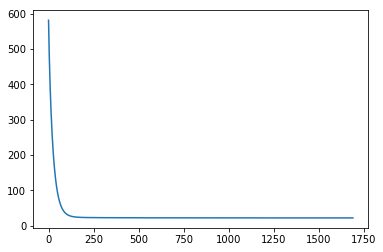

In [21]:
# define feature transform
_,mu,sigma=polyFv(xtrain,(0,1))
fmap=lambda x: polyFv(x,(0,1),mu,sigma)
# train model
w,loss = GD(xtrain,ytrain,fmap,optim,lossSquared)
# evaluate on train and val sets
lossTrain=lossSquared(fmap(xtrain),ytrain,w)
lossVal=lossSquared(fmap(xval),yval,w)
print('[%d iter] train RMSE %.4f, val RMSE %.4f'%(len(loss),sqrt(lossTrain),sqrt(lossVal)))
# plot the loss value over iterations, to observe the learning process
plt.plot(loss)

Now we can explore some more feature spaces...

In [22]:
fsets=((0,),(0,1),(0,1,2),(0,1,2,3))  # try others!

models={}
for f in fsets:
    models[f]={}
    _,mu,sigma=polyFv(xtrain,f)
    fmap=lambda x: polyFv(x,f,mu,sigma)
    models[f]['w'],models[f]['loss'] = GD(xtrain,ytrain,fmap,optim,lossSquared)
    models[f]['lossTrain']=lossSquared(fmap(xtrain),ytrain,models[f]['w'])
    models[f]['lossVal']=lossSquared(fmap(xval),yval,models[f]['w'])


In [23]:
for f in fsets:
    print('Model %s: train RMSE %.4f, val RMSE %.4f' %(f,sqrt(models[f]['lossTrain']),sqrt(models[f]['lossVal'])))


Model (0,): train RMSE 9.0047, val RMSE 10.3300
Model (0, 1): train RMSE 4.6887, val RMSE 5.4445
Model (0, 1, 2): train RMSE 3.6370, val RMSE 5.1796
Model (0, 1, 2, 3): train RMSE 3.5178, val RMSE 5.6626


Based on the exploration above, at this point you will have selected a model (i.e., feature space in which a linear model operates). Now let's see what changes when we move to an asymmetric loss.

In [24]:
def asymmLoss(X, y,w, alpha,getGrad=False):
    """
    Get the asymmetric loss given data X, weight w and ground truth y

    Parameters
    ----------
    X : 2D array
        N x d+1 design matrix (row per example)
    y : 1D array
        Observed function values
    w : 1D array
        d+1 length vector
    Returns
    -------
    loss : a scalar
        The loss calculated by equation in problem set 1
    """
    
    # asymmetric loss weighs negative errors (i.e., underestimated values) 
    # with alpha, and positive errors with 1.
    yhat = np.dot(X,w)
    err = np.squeeze(yhat)-y # prediction error values, for all the points in x
    weights=np.ones(err.shape)
    weights[err<0]=alpha
    
    loss = np.mean(weights*(err**2))
    if getGrad:
        grad = 2*np.mean(X*(weights*err).reshape(err.shape[0],1),axis=0)
        return loss, grad.reshape(w.shape)
    else:
        return loss    

In [25]:
# for convenience, we will define this lambda expression so we could call it inside GD without passing alpha to GD (which does
# not expect it -- we sort of make the asymmetric loss backward compatible...)
def aloss(alpha):
    return lambda x,y,w,getGrad: asymmLoss(x,y,w,alpha,getGrad)

We can now train a model, say a linear one, using code very similar to what we did before (the only difference is in the use of
the asymmetric loss, both in calling GD and in evaluating the resulting model on the val set

In [26]:
alpha=0.05

_,mu,sigma=polyFv(xtrain,(0,1))
fmap=lambda x: polyFv(x,(0,1),mu,sigma)
w,loss = GD(xtrain,ytrain,fmap,optim,aloss(alpha))
rmseTrain=lossSquared(fmap(xtrain),ytrain,w)
rmseVal=lossSquared(fmap(xval),yval,w)
alossVal=asymmLoss(fmap(xval),yval,w,alpha)
# corrected code follows (printing rmseTrain/rmseVal instead of lossTrain/lossVal):
# (Thanks to Yuxin Guan for pointing this out. --KG 10/16/2019)
print('[%d iter] train RMSE %.4f, val RMSE %.4f, weighted %.4f'%(len(loss),sqrt(rmseTrain),sqrt(rmseVal),sqrt(alossVal)))
# original code is below:
#print('[%d iter] train RMSE %.4f, val RMSE %.4f, weighted %.4f'%(len(loss),sqrt(lossTrain),sqrt(lossVal),sqrt(alossVal)))

[8615 iter] train RMSE 6.2048, val RMSE 7.1340, weighted 1.8582


Now we can experiment, using the validation set to select the model class and set parameter values (similarly to what was done with symmetric loss).

When we are done, we can evaluate the best model we have found on the test set.

In [27]:
modelsA={}
for f in fsets:
    modelsA[f]={}
    _,mu,sigma=polyFv(xtrain,f)
    fmap=lambda x: polyFv(x,f,mu,sigma)
    modelsA[f]['w'],modelsA[f]['loss'] = GD(xtrain,ytrain,fmap,optim,aloss(0.05))
    modelsA[f]['lossTrain']=lossSquared(fmap(xtrain),ytrain,modelsA[f]['w'])
    modelsA[f]['lossVal']=lossSquared(fmap(xval),yval,modelsA[f]['w'])
    modelsA[f]['aloss']=asymmLoss(fmap(xval),yval,modelsA[f]['w'],alpha)

In [28]:
for f in fsets:
    print('Model %s: train RMSE %.4f, val RMSE %.4f, rMASE %.4f' %(f,sqrt(modelsA[f]['lossTrain']),sqrt(modelsA[f]['lossVal']),sqrt(modelsA[f]['aloss'])))

Model (0,): train RMSE 12.6276, val RMSE 13.9231, rMASE 3.4224
Model (0, 1): train RMSE 6.2048, val RMSE 7.1340, rMASE 1.8582
Model (0, 1, 2): train RMSE 5.7862, val RMSE 6.8865, rMASE 1.9852
Model (0, 1, 2, 3): train RMSE 5.2866, val RMSE 6.6884, rMASE 2.3909


All right, we now have a model selected under regular squared loss, and a model selected under asymmetric loss. We can evaluate each of these two models on the test set, with its "native" loss and with the other loss (so you will get a total of four values: "symmetric model with symmetric loss", "symmetric model with asymmetric loss" etc.)

The best model (in terms of asymmetric loss on val) is the linear model. Let's see what it does on test (both with respect to the asymmetric loss it was trained with, and to the original squared loss).

In [29]:
_,mu,sigma=polyFv(xtrain,(0,1))
fmap=lambda x: polyFv(x,(0,1),mu,sigma)
lossTestAA=asymmLoss(fmap(xtest),ytest,modelsA[(0,1)]['w'],alpha) # AA = train with aloss, test with aloss
lossTestAS=lossSquared(fmap(xtest),ytest,modelsA[(0,1)]['w'])
print('Asym model, asym loss (test): %.4f, sym loss (test): %.4f'%(lossTestAA,lossTestAS))

Asym model, asym loss (test): 1.8942, sym loss (test): 36.3242


Now let's compute the test losses for the best symmetric loss model.

In [30]:
_,mu,sigma=polyFv(xtrain,(0,1,2))
fmap=lambda x: polyFv(x,(0,1,2),mu,sigma)
lossTestSA=asymmLoss(fmap(xtest),ytest,models[(0,1,2)]['w'],alpha) # AA = train with aloss, test with aloss
lossTestSS=lossSquared(fmap(xtest),ytest,models[(0,1,2)]['w'])
print('Sym model, asym loss (test): %.4f, sym loss (test): %.4f'%(lossTestSA,lossTestSS))

Sym model, asym loss (test): 3.0486, sym loss (test): 10.9973


What can we conclude from this comparison?... Which model is "better", and in what sense? First, we can see that the models (trained on train set and selected on val set) are doing a reasonable job optimizing the loss used as the training objective on the test set: the results on test set are not significantly different from those on val (but of course quite different from the results on train -- so the strategy of using a val set for model selection paid off.)

Now, we see that the "asymmetric model" (model trained on asymmetric loss) achieves lower asymmetric loss on test than the symmetric model (trained with regular squared loss), and vice versa. This is not surprising: each model is, as we noted just above, doing a decent job in minimizing the objective it was trained to minimize.

One could be tempted to think of the squared loss as some sort of "normal loss", and draw a conclusion that since the squared loss of the symmetric model on test is lower, it's somehow better. But that would ignore the very motivation we stated for considering the asymmetric loss: our real objective here (making sure we estimate house prices accurately, but especially not over-estimating) is not consistent with squared loss. So in a sense, it's besides the point to do the "cross-loss" comparison.

The main conclusion is that if we know that our objective (behind the prediction task) is better represented by loss B than loss A, we should use loss B in both training and model selection; that will generally lead to better success in minimizing loss B on future data.